<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/User_Input_Based_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
import pandas as pd

### data set reading

In [3]:
filename = input("Enter the name of the CSV file: ")
df = pd.read_csv(f"{filename}.csv")
df.head()

Enter the name of the CSV file: HDFCBANK


,Date,Close/Last,Volume,Open,High,Low
0,02/1/1996,2.975,412000,2.980,3.025,2.95
1,03/1/1996,2.985,284000,2.975,2.995,2.95
2,04/1/1996,2.965,282000,2.985,2.980,2.94
3,05/1/1996,2.960,189000,2.965,2.980,2.95
4,08/1/1996,2.925,237000,2.960,2.950,2.91


### preprocessing data set to perform analysis

In [4]:
df.shape

(6673, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673 entries, 0 to 6672
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6673 non-null   object 
 1   Close/Last  6673 non-null   float64
 2   Volume      6673 non-null   int64  
 3   Open        6673 non-null   float64
 4   High        6673 non-null   float64
 5   Low         6673 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 312.9+ KB


In [6]:
df1 = df.iloc[:,1]
df1.head()

0    2.975
1    2.985
2    2.965
3    2.960
4    2.925
Name: Close/Last, dtype: float64

In [7]:
df1.tail()

6668    1355.650024
6669    1352.599976
6670    1371.250000
6671    1395.800049
6672    1397.099976
Name: Close/Last, dtype: float64

In [8]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    2.975
1    2.985
2    2.965
3    2.960
4    2.925
Name: Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

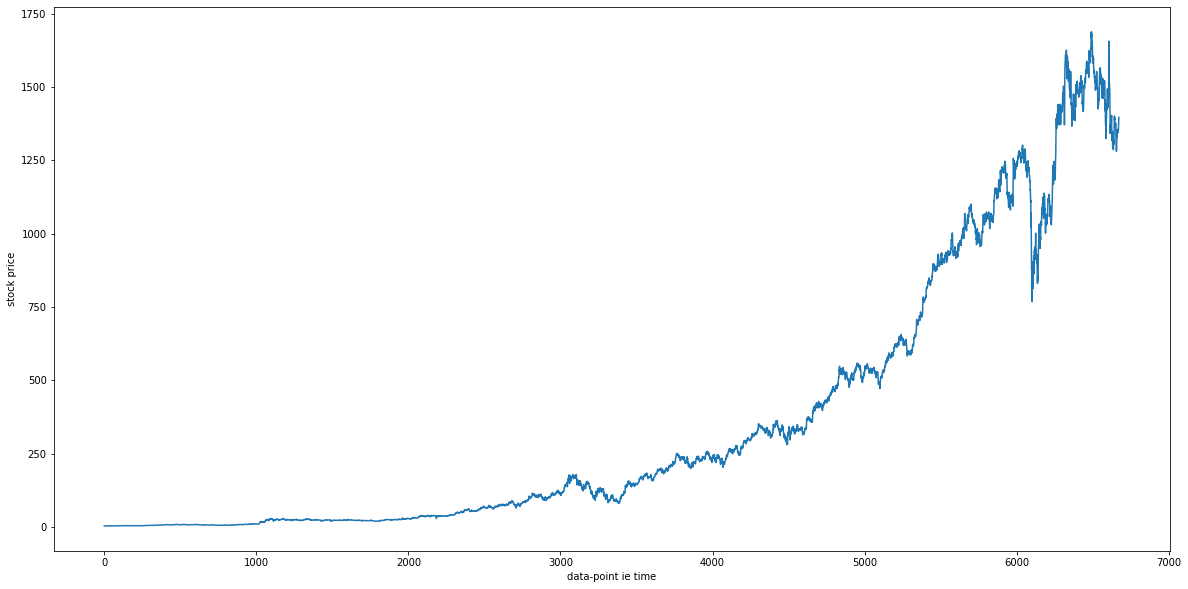

In [9]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

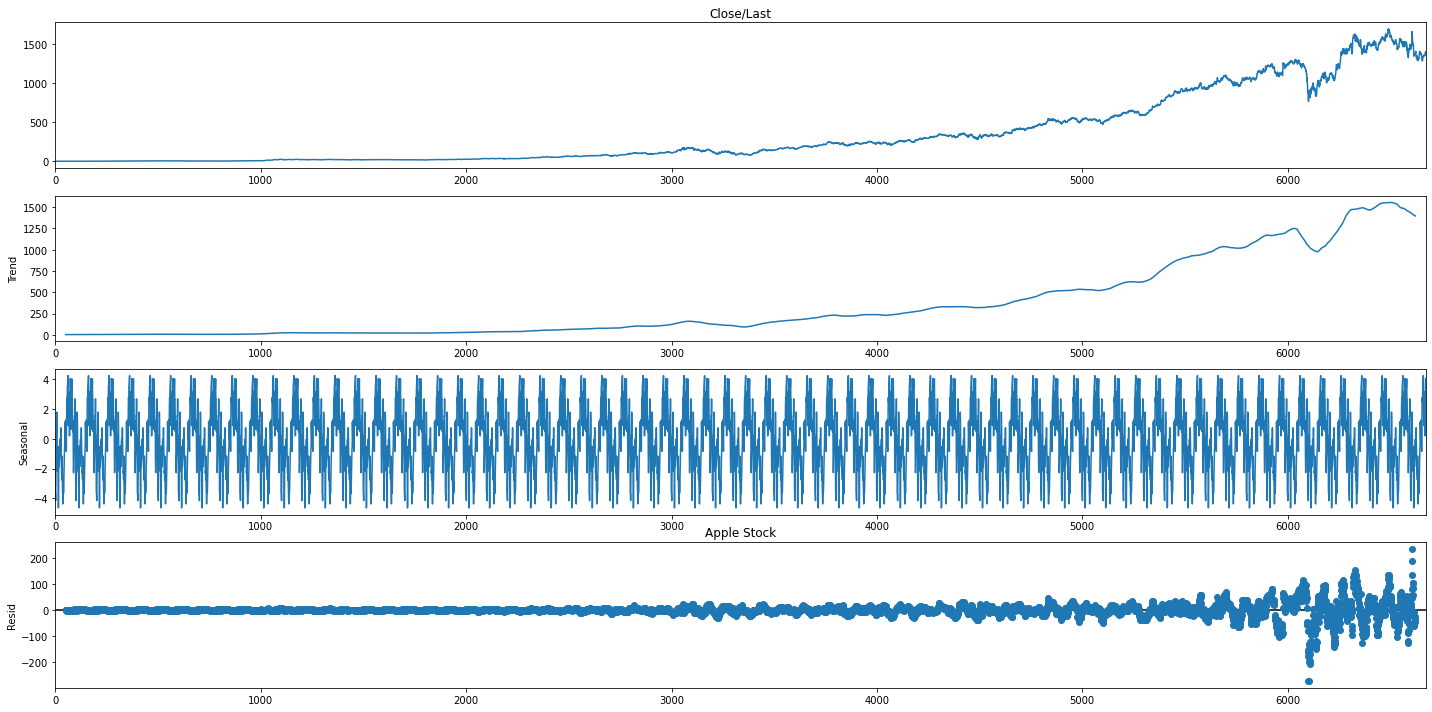

In [10]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [12]:
df1.shape

(6673,)

In [13]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[3.20234373e-04]
 [3.26164640e-04]
 [3.14304107e-04]
 ...
 [8.11743729e-01]
 [8.26302562e-01]
 [8.27073453e-01]]

 df1 present shape :  (6673, 1)


### splitting data (70/30)

In [15]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  4671
Test Size :  2002


In [16]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (4671, 1)
Test Data Shape:  (2002, 1)


### | windowing data set |

In [17]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [18]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4570, 100) (4570,)
(1901, 100) (1901,)


In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [24]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
72/72 [==============================] - 26s 272ms/step - loss: 4.4636e-04 - val_loss: 0.0016
Epoch 2/2
72/72 [==============================] - 17s 241ms/step - loss: 1.8964e-05 - val_loss: 0.0027


In [25]:
y_pred = scaler.inverse_transform(model.predict(X_test))

60/60 [==============================] - 4s 49ms/step


In [26]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
y_pred[:5]

array([[440.15527],
       [440.95728],
       [441.82935],
       [442.73505],
       [443.6623 ]], dtype=float32)

In [28]:
y_test[:5]

array([[448.625   ],
       [447.649994],
       [445.774994],
       [448.325012],
       [455.924988]])

### evaluation

In [29]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  87.56754973393586


In [30]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.9373274839833836


### visualization + plotting

143/143 [==============================] - 7s 50ms/step


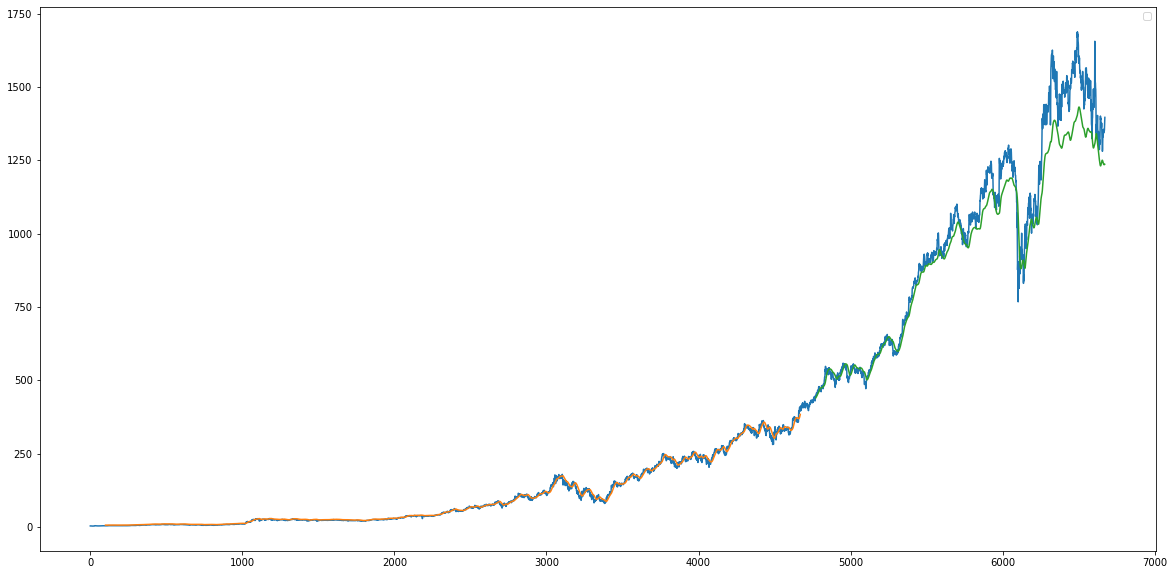

In [31]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [32]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
print(scaler.inverse_transform(lst_output))

[[1239.7539957 ]
 [1240.6987824 ]
 [1240.66179501]
 [1239.51468324]
 [1237.29463552]
 [1234.128796  ]
 [1230.18310541]
 [1225.6322488 ]
 [1220.638046  ]
 [1215.34030534]
 [1209.85581855]
 [1204.27544595]
 [1198.66773485]
 [1193.08354291]
 [1187.55754581]
 [1182.1132627 ]
 [1176.76466438]
 [1171.51908801]
 [1166.3798504 ]
 [1161.34805715]
 [1156.42109502]
 [1151.59645127]
 [1146.87070861]
 [1142.24065072]
 [1137.7027598 ]
 [1133.25321648]
 [1128.88890498]
 [1124.60751359]
 [1120.40562499]
 [1116.28032443]]


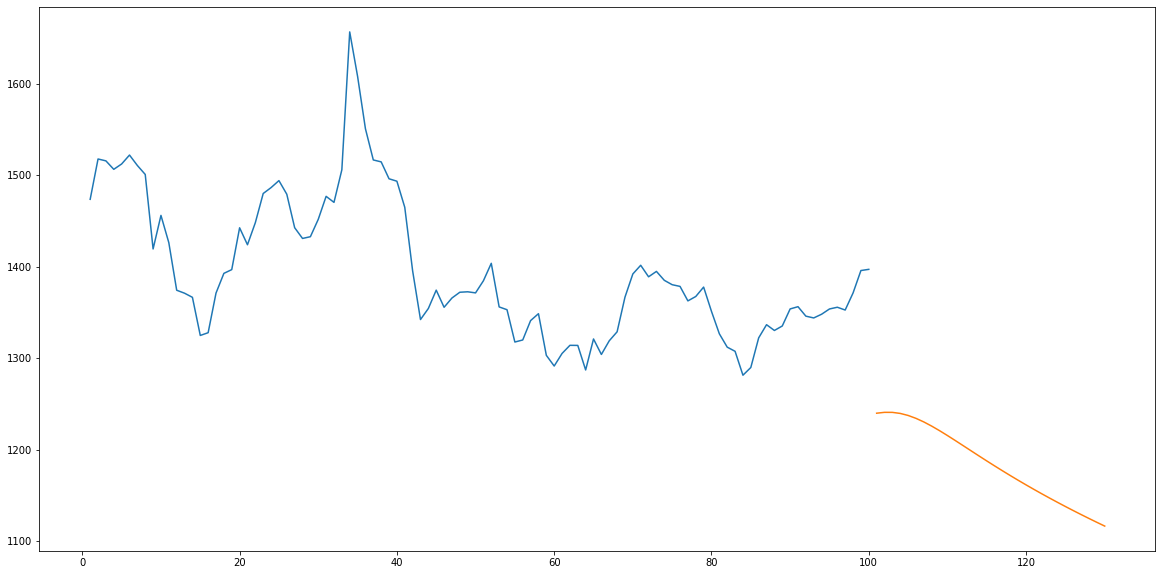

In [37]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))